### Audio Recognition for Speech Commands dataset

#### 1.1 Importing the Speech Commands dataset

In [1]:
import os
import pathlib
import tensorflow as tf

DATASET_PATH = 'Audio_Dataset_8'
data_dir = pathlib.Path(DATASET_PATH)

In [2]:
#Getting the different commands in the dataset
commands = [x for x in os.listdir(DATASET_PATH) if x != 'README.md']
print(f"Commands : {commands}")

Commands : ['Apple', 'Cat', 'Paper', 'Tree', 'Lamp', 'Fork', 'Sun', 'Car', '#unknown#', '.DS_Store', 'Radio', 'Amazon', 'Television', 'Donut', 'Dog', 'Flower', 'Bike', 'Moon', 'Sandals', 'Chair', 'Soap', 'Shower', 'Pen', 'Pants', 'Netflix', '#noise#', 'Bamboo', 'Internet', 'Table', 'Aeroplane', 'Window', 'Hockey', 'Coffee', 'Book', 'Towel', 'Umbrella', 'Wallet', 'Phone', 'Spoon', 'Keys', 'Hat', 'Banana', 'Backpack', 'Toothpaste', 'Computer', 'Shoes', 'Toothbrush', 'Electricity', 'Shirt', 'Clock', 'Shark', 'Door', 'Knife']


In [3]:
import numpy as np

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
sampling_rate = 64000
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=128,
    validation_split=0.2,
    seed=0,
    output_sequence_length=sampling_rate,
    subset="both"
)

labels = np.array(train_ds.class_names)
print('----------------------------------------------')
print(f'Labels : {labels}')

Found 1040 files belonging to 52 classes.
Using 832 files for training.
Using 208 files for validation.
----------------------------------------------
Labels : ['#noise#' '#unknown#' 'Aeroplane' 'Amazon' 'Apple' 'Backpack' 'Bamboo'
 'Banana' 'Bike' 'Book' 'Car' 'Cat' 'Chair' 'Clock' 'Coffee' 'Computer'
 'Dog' 'Donut' 'Door' 'Electricity' 'Flower' 'Fork' 'Hat' 'Hockey'
 'Internet' 'Keys' 'Knife' 'Lamp' 'Moon' 'Netflix' 'Pants' 'Paper' 'Pen'
 'Phone' 'Radio' 'Sandals' 'Shark' 'Shirt' 'Shoes' 'Shower' 'Soap' 'Spoon'
 'Sun' 'Table' 'Television' 'Toothbrush' 'Toothpaste' 'Towel' 'Tree'
 'Umbrella' 'Wallet' 'Window']


### 1.2 Preprocess the data

In [5]:
train_ds.element_spec

(TensorSpec(shape=(None, 64000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [6]:
# Squeezing the extra dimension of channels as there is only one

def squeeze(audio, labels) :
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [7]:
train_ds.element_spec

(TensorSpec(shape=(None, 64000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [8]:
#Splitting the validation set into validation and test sets

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [9]:
for sample_audio, sample_labels in train_ds.take(1) :
  print(f"Audio Shape : {sample_audio.shape}")
  print(f"Label Shape : {sample_labels.shape}")

Audio Shape : (128, 64000)
Label Shape : (128,)


In [10]:
from IPython import display
display.display(display.Audio(sample_audio[3], rate=sampling_rate))

### 1.3 Plotting the audio waveforms

In [11]:
labels[[1, 0, 2, 1]]

array(['#unknown#', '#noise#', 'Aeroplane', '#unknown#'], dtype='<U11')

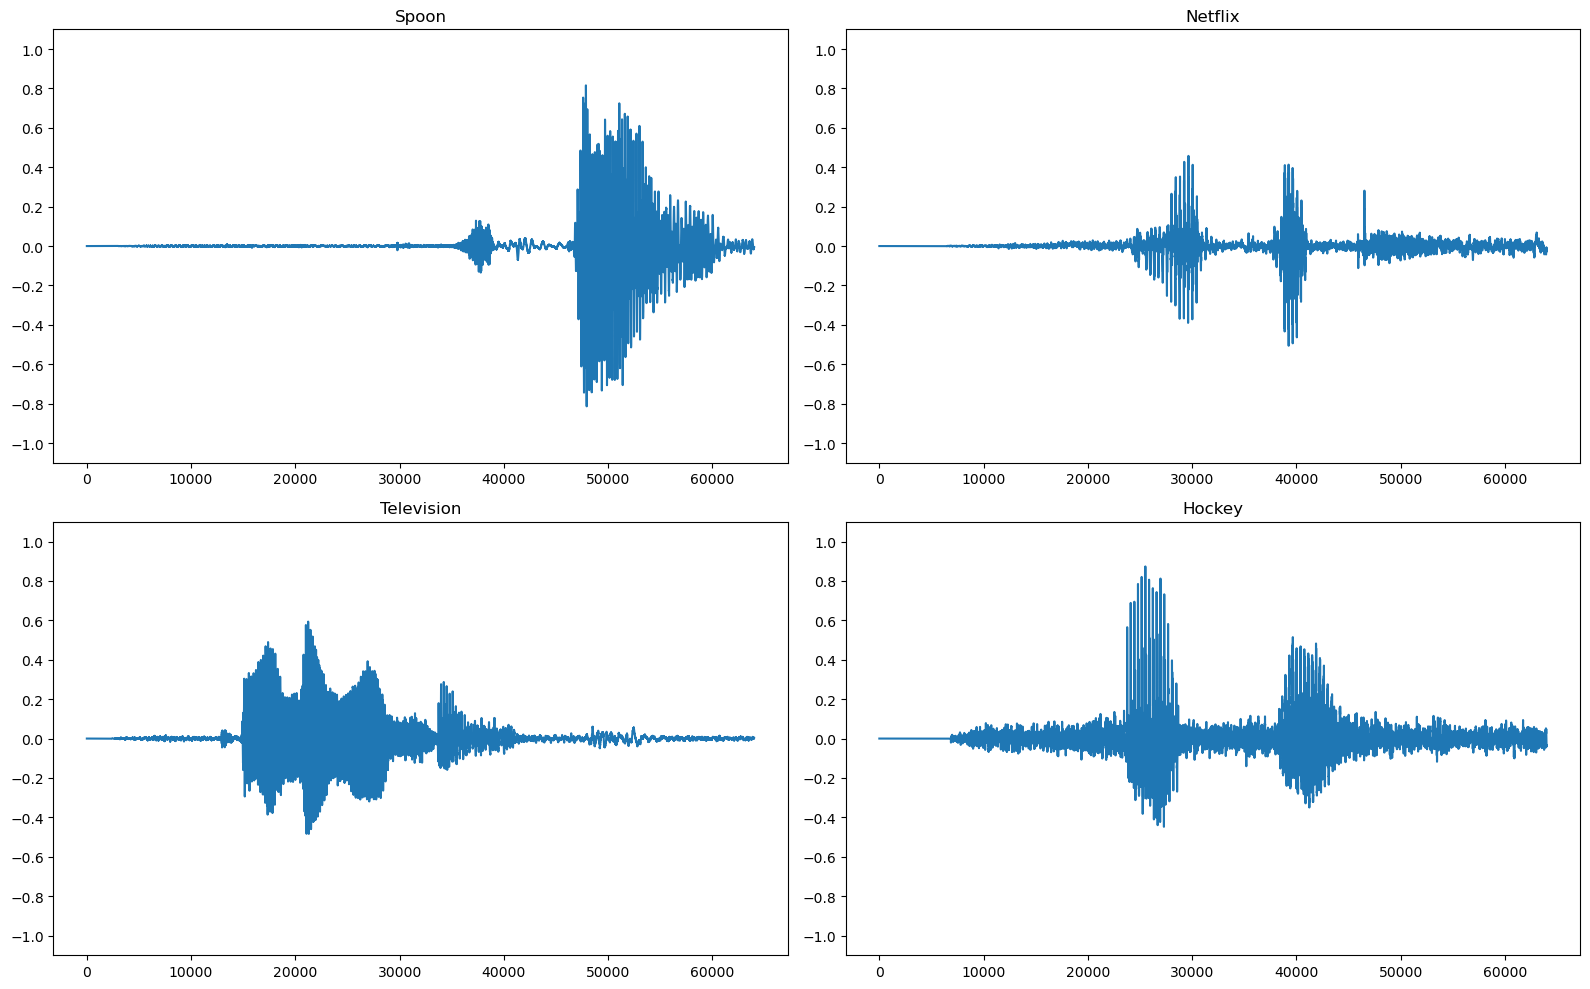

In [12]:
#Creating a plot with 9 audio samples and corresponding labels
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

rows = 2
cols = 2

for i in range(1, rows * cols + 1) :
  plt.subplot(rows, cols, i)
  audio_sample = sample_audio[i-1]
  audio_label = labels[sample_labels[i-1]]
  plt.plot(audio_sample)
  plt.title(audio_label)
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])
  plt.tight_layout()

### 1.4 Converting the audio data waveforms into spectrograms

In [13]:
def get_spectrogram(waveform) :
  # 1. Waveform to Spectrogram using Short-time Fourier Transform
  frame_length = int(sampling_rate * 0.025)  # 25 ms frame length
  frame_step = int(sampling_rate * 0.010)   # 10 ms frame step
  spectrogram = tf.signal.stft(waveform,
                              frame_length=frame_length,
                              frame_step=frame_step)

  # 2. Getting the magnitude of Spectrogram
  spectrogram = tf.abs(spectrogram)

  # 3. Adding a new axis to make it look like (batch, samples, channels) form of an image
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [14]:

from IPython import display

for i in range(3) :
  label = sample_labels[i]
  waveform = sample_audio[i]
  spectrogram = get_spectrogram(waveform)

  print(f"Label            : {labels[label]}")
  print(f"Waveform Shape   : {waveform.shape}")
  print(f"Spectrogram Shape : {spectrogram.shape}")
  display.display(display.Audio(waveform, rate=sampling_rate))

Label            : Spoon
Waveform Shape   : (64000,)
Spectrogram Shape : (98, 1025, 1)


Label            : Netflix
Waveform Shape   : (64000,)
Spectrogram Shape : (98, 1025, 1)


Label            : Television
Waveform Shape   : (64000,)
Spectrogram Shape : (98, 1025, 1)


In [15]:
# Plotting the spectrogram

def plot_spectrogram(spectrogram, ax) :

  # 1. Check if length of spectrogram.shape == 3 else raise an AssertionError and squezze the extra dim
  if(len(spectrogram.shape) > 2) :
    # assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)

  # 2. Do a logarithmic transformation on the spectrogram and add a epsilon to avoid taking log(0)
  log_spec = np.log(spectrogram + np.finfo(float).eps)
  height, width = log_spec.shape[0], log_spec.shape[1]

  # 3. Set X and Y for the colormesh
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

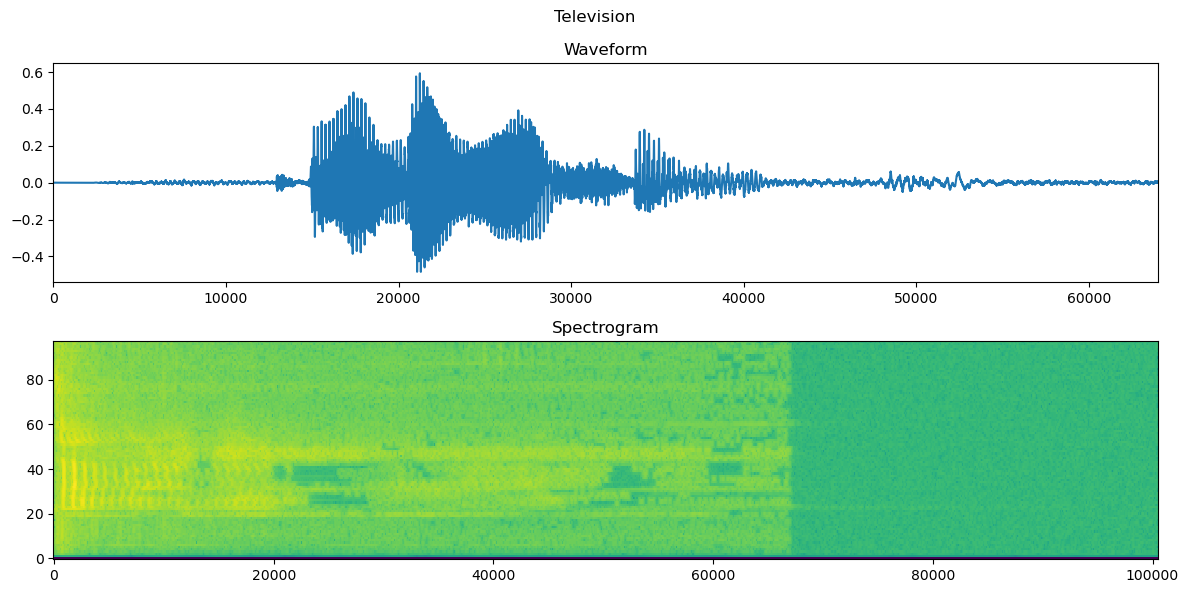

In [16]:
# Plotting the waveform and spectrogram

fig, axes = plt.subplots(2, figsize=(12, 6))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim(0, sampling_rate)

plot_spectrogram(spectrogram, axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(labels[label].title())
plt.tight_layout()
plt.show()

### 1.5 Create Spectrogram datasets from waveform data

In [17]:
def make_spec_ds(ds) :
  return ds.map(
      map_func = lambda audio, label : (get_spectrogram(audio), label),
      num_parallel_calls = tf.data.AUTOTUNE
  )

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

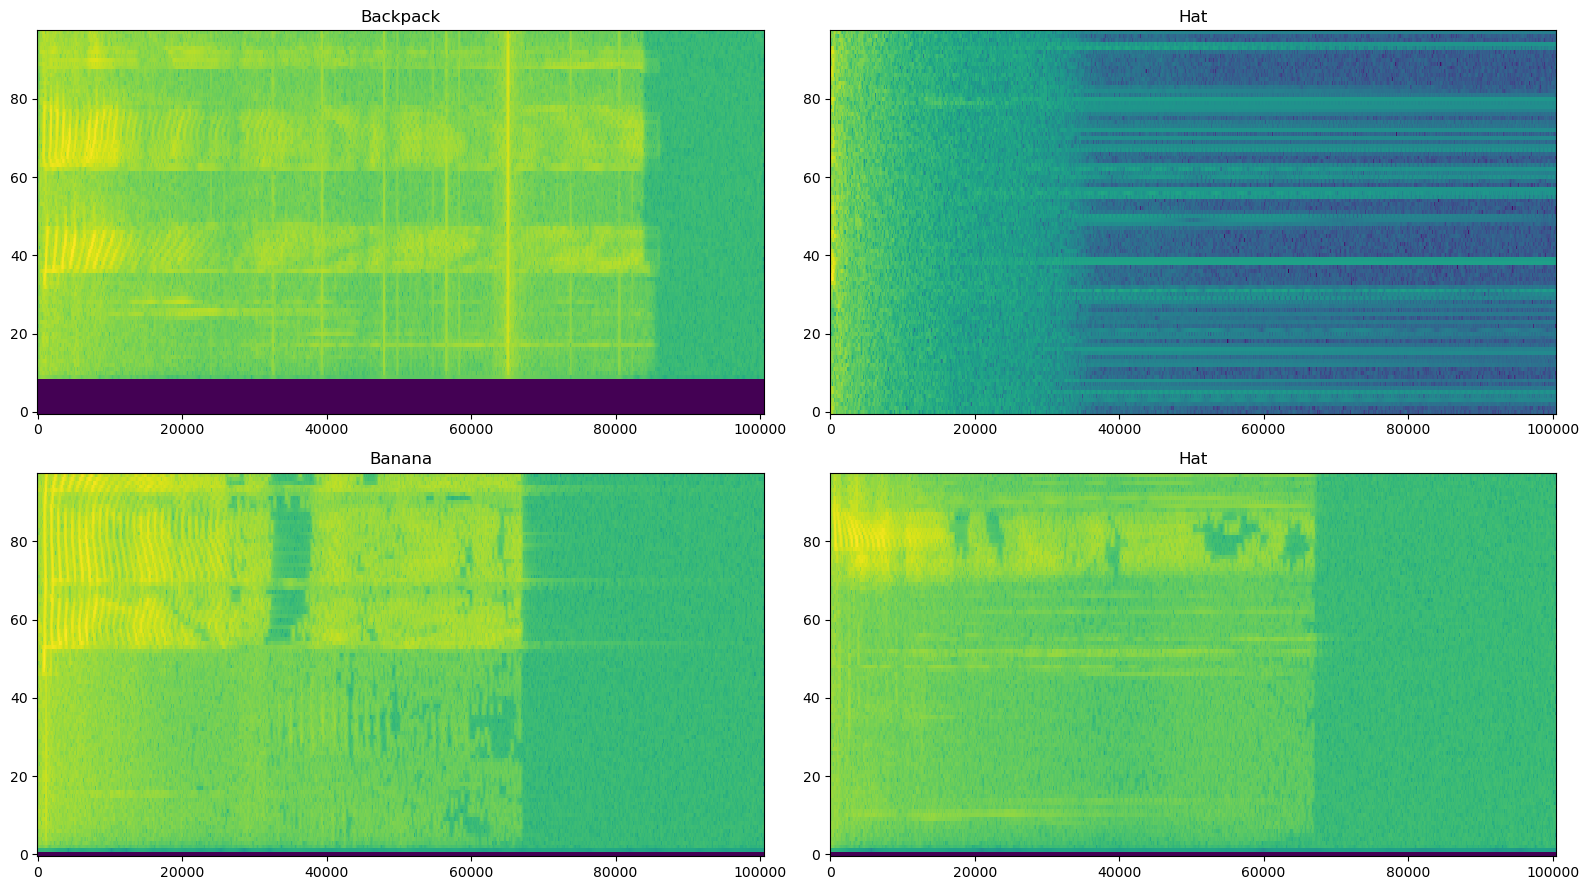

In [18]:
# Plotting the spectrograms

for sample_spect, sample_spect_labels in train_spectrogram_ds.take(4) :
  break

rows = 2
cols = 2
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n) :
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(sample_spect[i].numpy(), ax)
  ax.set_title(labels[sample_spect_labels[i].numpy()])

plt.tight_layout()
plt.show()

### 2.1 Build and Train the model

In [19]:
# Add cache and prefetch to reduce latency

train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [20]:
# Building a Convolutional Model as audio data is transformed to spectrogram images

input_shape = sample_spect.shape[1:]
print(f"Input Shape : {input_shape}")
num_labels = len(labels)
print(f"Output Units : {num_labels}")


Input Shape : (98, 1025, 1)
Output Units : 52


In [21]:
from tensorflow.keras import layers, models
from time import time
EPOCHS = 30

In [22]:
model_names = ["GRU 2", "BiRNN 1", "CRNN 1", "CRNN 2"]
hidden_units = [ "64(3 Layers)", "128(GRU Layer)", "64(GRU Layer)", "128(LSTM Layer)"]

training_accuracies = []
training_losses = []
training_latencies = []

validation_accuracies = []
validation_losses = []

testing_accuracies = []
testing_losses = []
prediction_latencies = []
prediction_accuracies = []

In [23]:
def plot_training_curve(model_name, history) :
    #Plotting the Loss and Accuracy Curves
    metrics = history.history
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.ylim(0, max(plt.ylim()))
    plt.legend(['loss', 'val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss [CrossEntropy]')

    plt.subplot(1, 2, 2)
    plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
    plt.legend(['accuracy', 'val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')
    plt.title(model_name)
    plt.show()

In [24]:
def train_model(model, model_name) :
    
    model.compile(
        optimizer = tf.keras.optimizers.legacy.Adam(),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics = ['accuracy'],
    )

    print(f"Training of {model_name} begins...")
    start_time = time()
    history = model.fit(
        train_spectrogram_ds,
        validation_data = val_spectrogram_ds,
        epochs = EPOCHS,
        verbose = 0
    )
    end_time = time()

    print(f"Training Accuracy : {history.history['accuracy'][-1]}")
    print(f"Training Loss : {history.history['loss'][-1]}")
    print(f"Validation Accuracy : {history.history['val_accuracy'][-1]}")
    print(f"Validation Loss : {history.history['val_loss'][-1]}")
    print(f"Training Latency of {model_name} is {end_time - start_time:.2f}s")

    training_accuracies.append(history.history['accuracy'][-1])
    training_losses.append(history.history['loss'][-1])
    validation_accuracies.append(history.history['val_accuracy'][-1])
    validation_losses.append(history.history['val_loss'][-1])
    training_latencies.append(end_time - start_time)
    
    plot_training_curve(model_name, history)

#### RNN Models : LSTM Layers

Training of LSTM 1 begins...
Training Accuracy : 0.784375011920929
Training Loss : 0.7379275560379028
Validation Accuracy : 0.72265625
Validation Loss : 1.0807992219924927
Training Latency of LSTM 1 is 149.01s


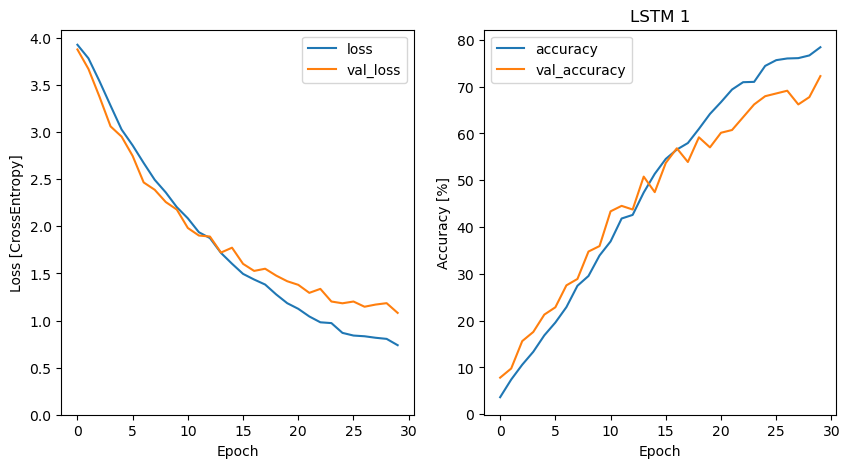

In [79]:
model_lstm_1 = models.Sequential([
    layers.Input(shape=input_shape[:2]),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

train_model(model_lstm_1, "LSTM 1")

Training of LSTM 2 begins...
Training Accuracy : 0.8891826868057251
Training Loss : 0.4152565598487854
Validation Accuracy : 0.794921875
Validation Loss : 0.8841995596885681
Training Latency of LSTM 2 is 244.09s


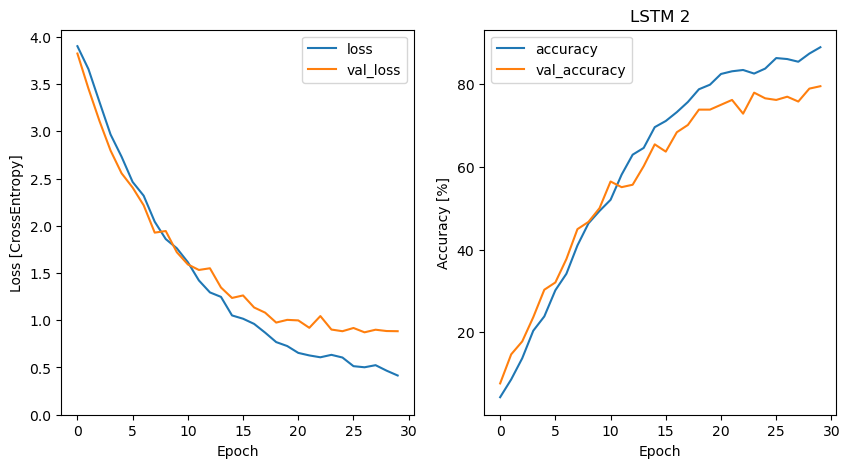

In [80]:
model_lstm_2 = models.Sequential([
    layers.Input(shape=input_shape[:2]),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(128),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

train_model(model_lstm_2, 'LSTM 2')

#### RNN Models : GRU Layers

Training of GRU 1 begins...
Training Accuracy : 0.8584134578704834
Training Loss : 0.5206665992736816
Validation Accuracy : 0.69921875
Validation Loss : 1.153734564781189
Training Latency of GRU 1 is 125.48s


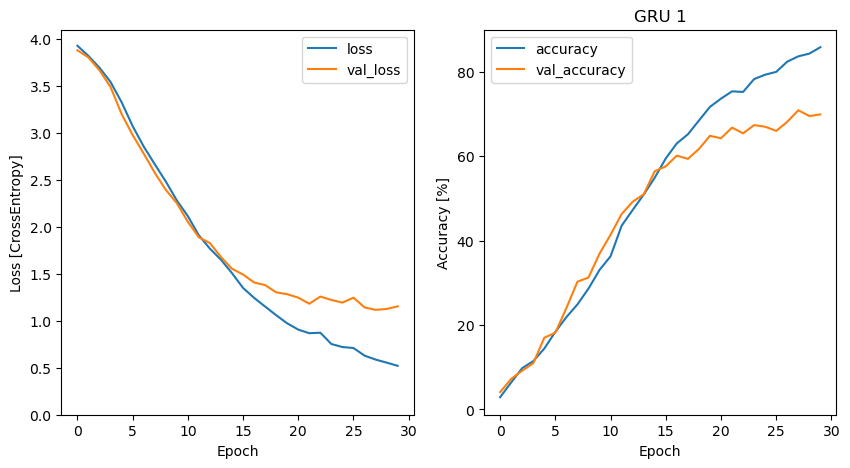

In [81]:
model_gru_1 = models.Sequential([
    layers.Input(shape=input_shape[:2]),
    layers.GRU(64, return_sequences=True),
    layers.GRU(64),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

train_model(model_gru_1, 'GRU 1')

Training of GRU 2 begins...


/Users/anand/miniconda3/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Training Accuracy : 0.45913460850715637
Training Loss : 1.8898729085922241
Validation Accuracy : 0.21250000596046448
Validation Loss : 3.258937358856201
Training Latency of GRU 2 is 38.02s


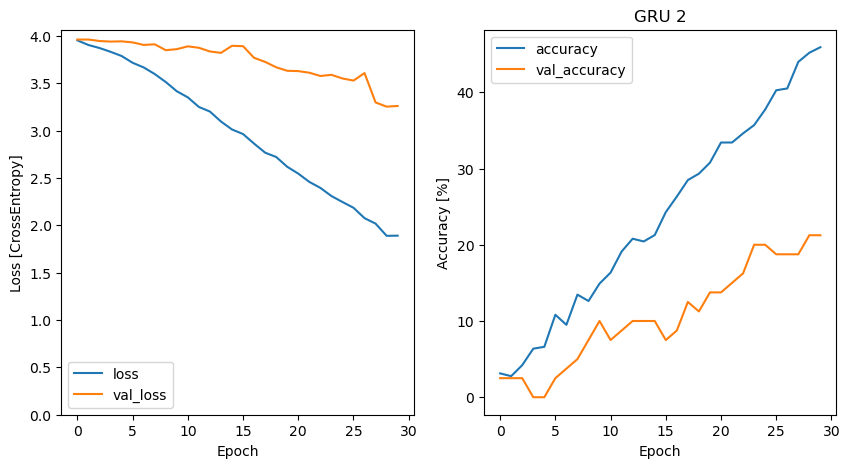

In [25]:
model_gru_2 = models.Sequential([
    layers.Input(shape=input_shape[:2]),
    layers.GRU(64, return_sequences=True),
    layers.GRU(64, return_sequences=True),
    layers.GRU(64),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

train_model(model_gru_2, 'GRU 2')

#### RNN Models : BiRNN 

Training of BiRNN 1 begins...
Training Accuracy : 0.5757211446762085
Training Loss : 1.5278059244155884
Validation Accuracy : 0.26249998807907104
Validation Loss : 3.3727996349334717
Training Latency of BiRNN 1 is 38.64s


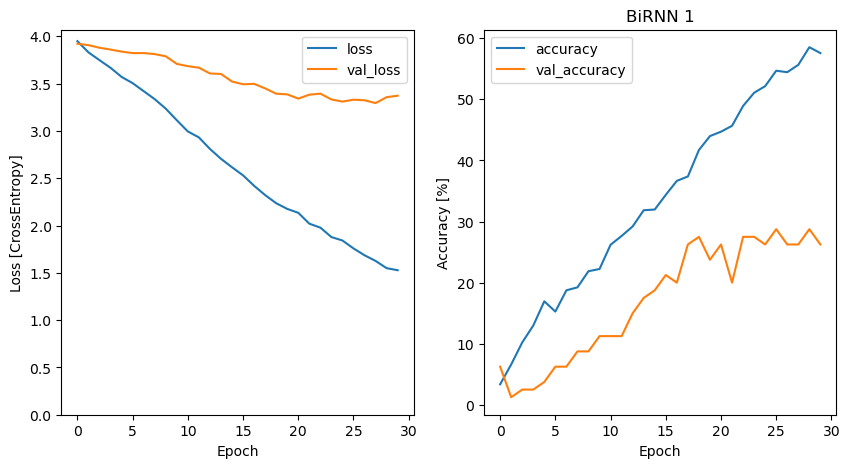

In [26]:
model_birnn_1 = models.Sequential([
    layers.Input(shape=input_shape[:2]),
    layers.Bidirectional(layers.GRU(64, return_sequences=True)),
    layers.Bidirectional(layers.GRU(64)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

train_model(model_birnn_1, 'BiRNN 1')

Training of BiRNN 2 begins...
Training Accuracy : 0.8786057829856873
Training Loss : 0.4433647096157074
Validation Accuracy : 0.796875
Validation Loss : 0.7574306726455688
Training Latency of BiRNN 2 is 218.33s


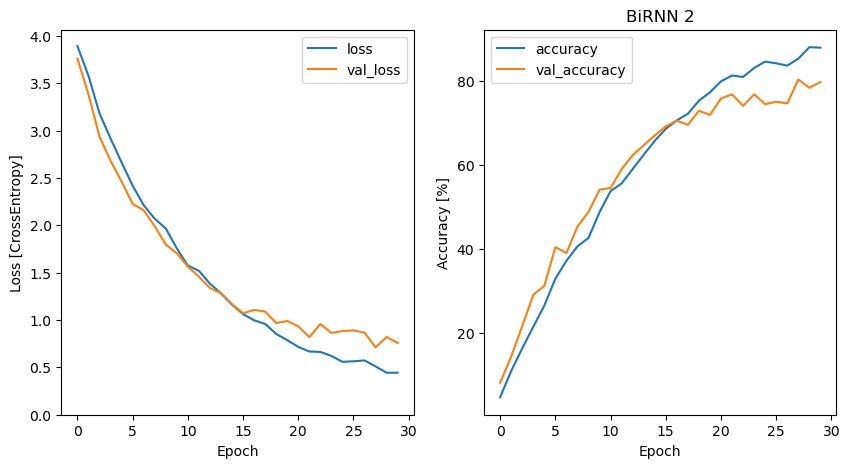

In [84]:
model_birnn_2 = models.Sequential([
    layers.Input(shape=input_shape[:2]),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

train_model(model_birnn_2, 'BiRNN 2')

#### RNN Models : CRNN

Training of CRNN 1 begins...
Training Accuracy : 0.7596153616905212
Training Loss : 1.0092991590499878
Validation Accuracy : 0.44999998807907104
Validation Loss : 2.108956813812256
Training Latency of CRNN 1 is 19.52s


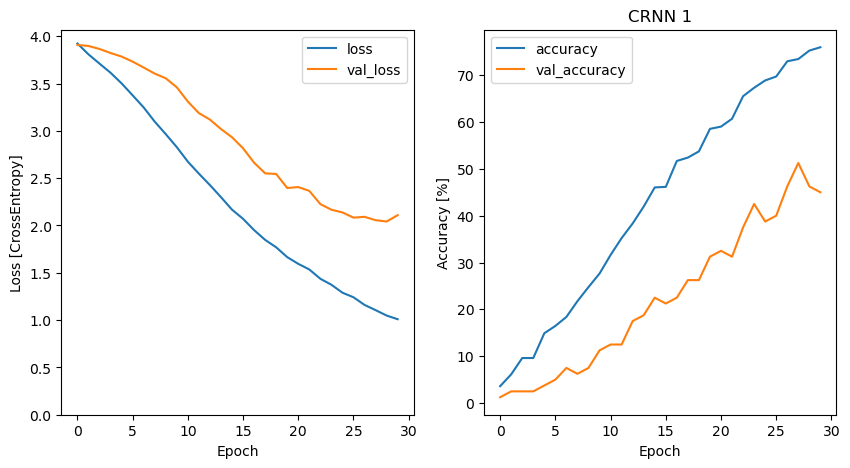

In [27]:
model_crnn_1 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Reshape((98, -1)),
    layers.Conv1D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.GRU(64, return_sequences=True)),
    layers.Bidirectional(layers.GRU(64)),
    layers.Dense(num_labels, activation='softmax')
])

train_model(model_crnn_1, "CRNN 1")

Training of CRNN 2 begins...
Training Accuracy : 0.9699519276618958
Training Loss : 0.13440126180648804
Validation Accuracy : 0.625
Validation Loss : 1.8512108325958252
Training Latency of CRNN 2 is 43.02s


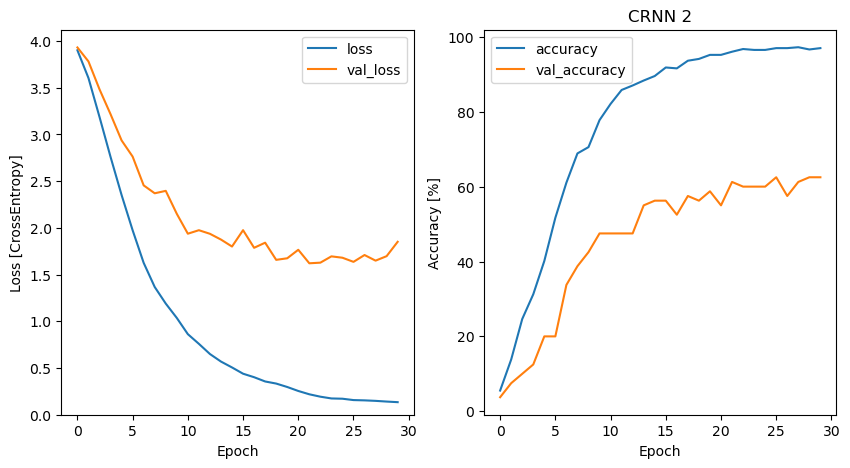

In [28]:
model_crnn_2 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Reshape((98, -1)),
    layers.Conv1D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(128)),
    layers.Dense(num_labels, activation='softmax')
])

train_model(model_crnn_2, "CRNN 2")

### 3.1 Evaluate the model performance

In [30]:
import seaborn as sns

def evaluate_model(model) :
    eval_dict = model.evaluate(test_spectrogram_ds, return_dict=True,  verbose=0)
    print(f"Test Accuracy and Loss Values : {eval_dict}")
    testing_accuracies.append(eval_dict['accuracy'])
    testing_losses.append(eval_dict['loss'])
    y_pred = tf.argmax(model.predict(test_spectrogram_ds), axis=1)
    y_true = tf.concat(list(test_spectrogram_ds.map(lambda spec, label : label)), axis=0)
    conf_mat = tf.math.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(50, 20))
    sns.heatmap(conf_mat,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

Test Accuracy and Loss Values : {'loss': 2.731255054473877, 'accuracy': 0.3203125}
1/1 [==============================] - 0s 365ms/step


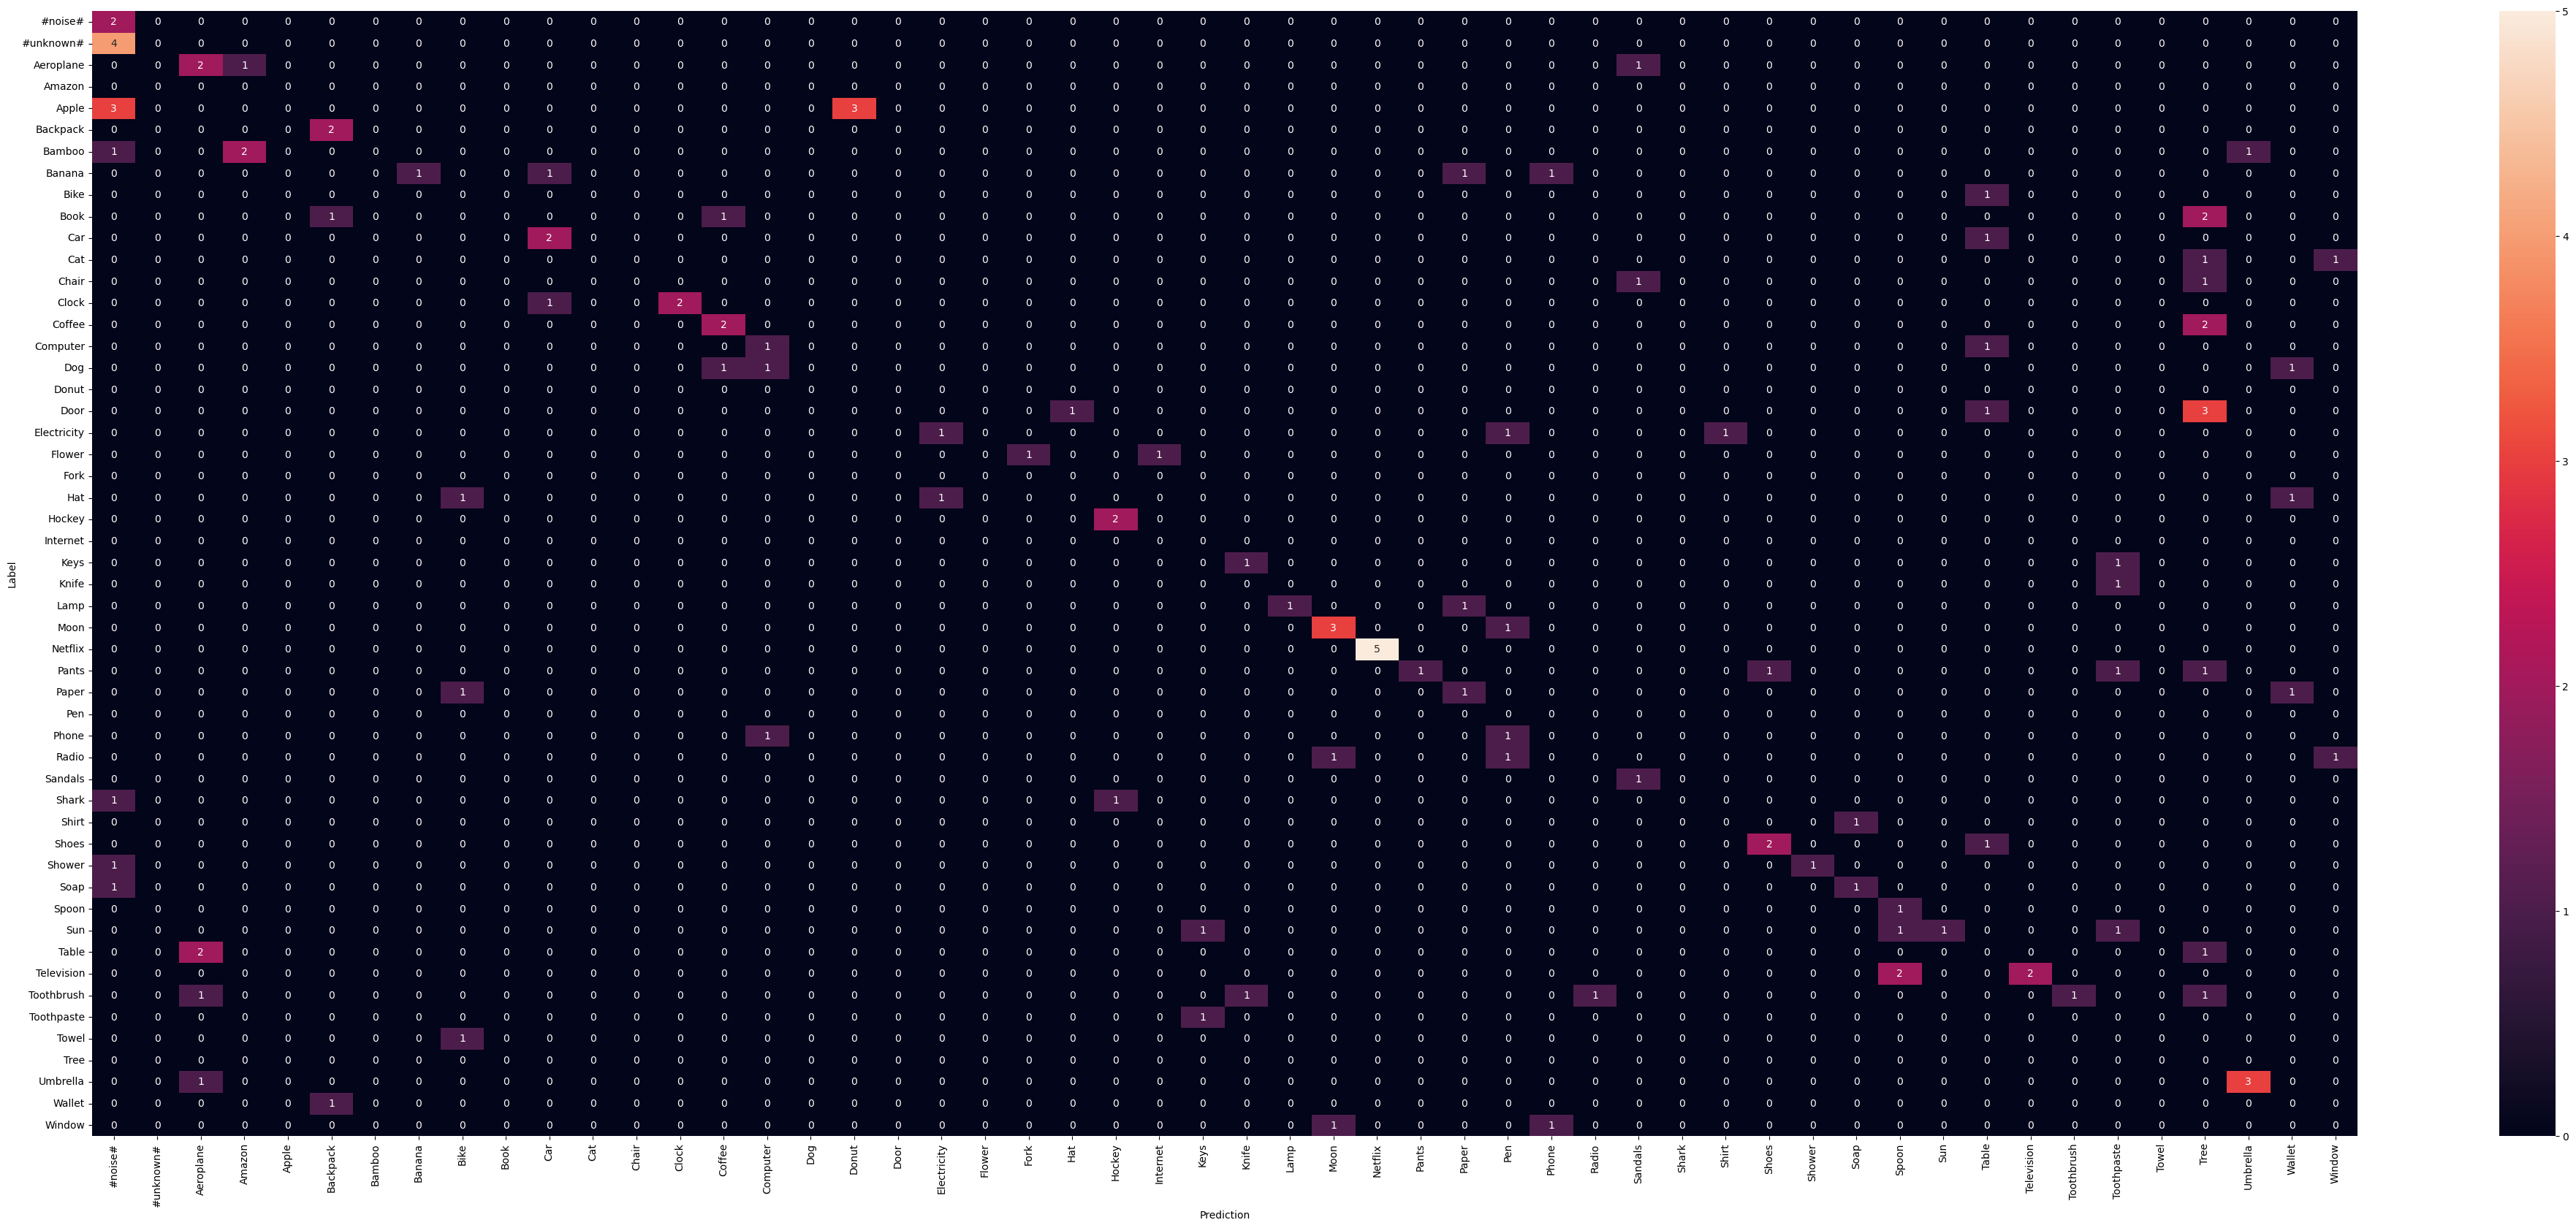

In [35]:
evaluate_model(model_gru_2)

Test Accuracy and Loss Values : {'loss': 2.4741029739379883, 'accuracy': 0.3828125}
1/1 [==============================] - 0s 77ms/step


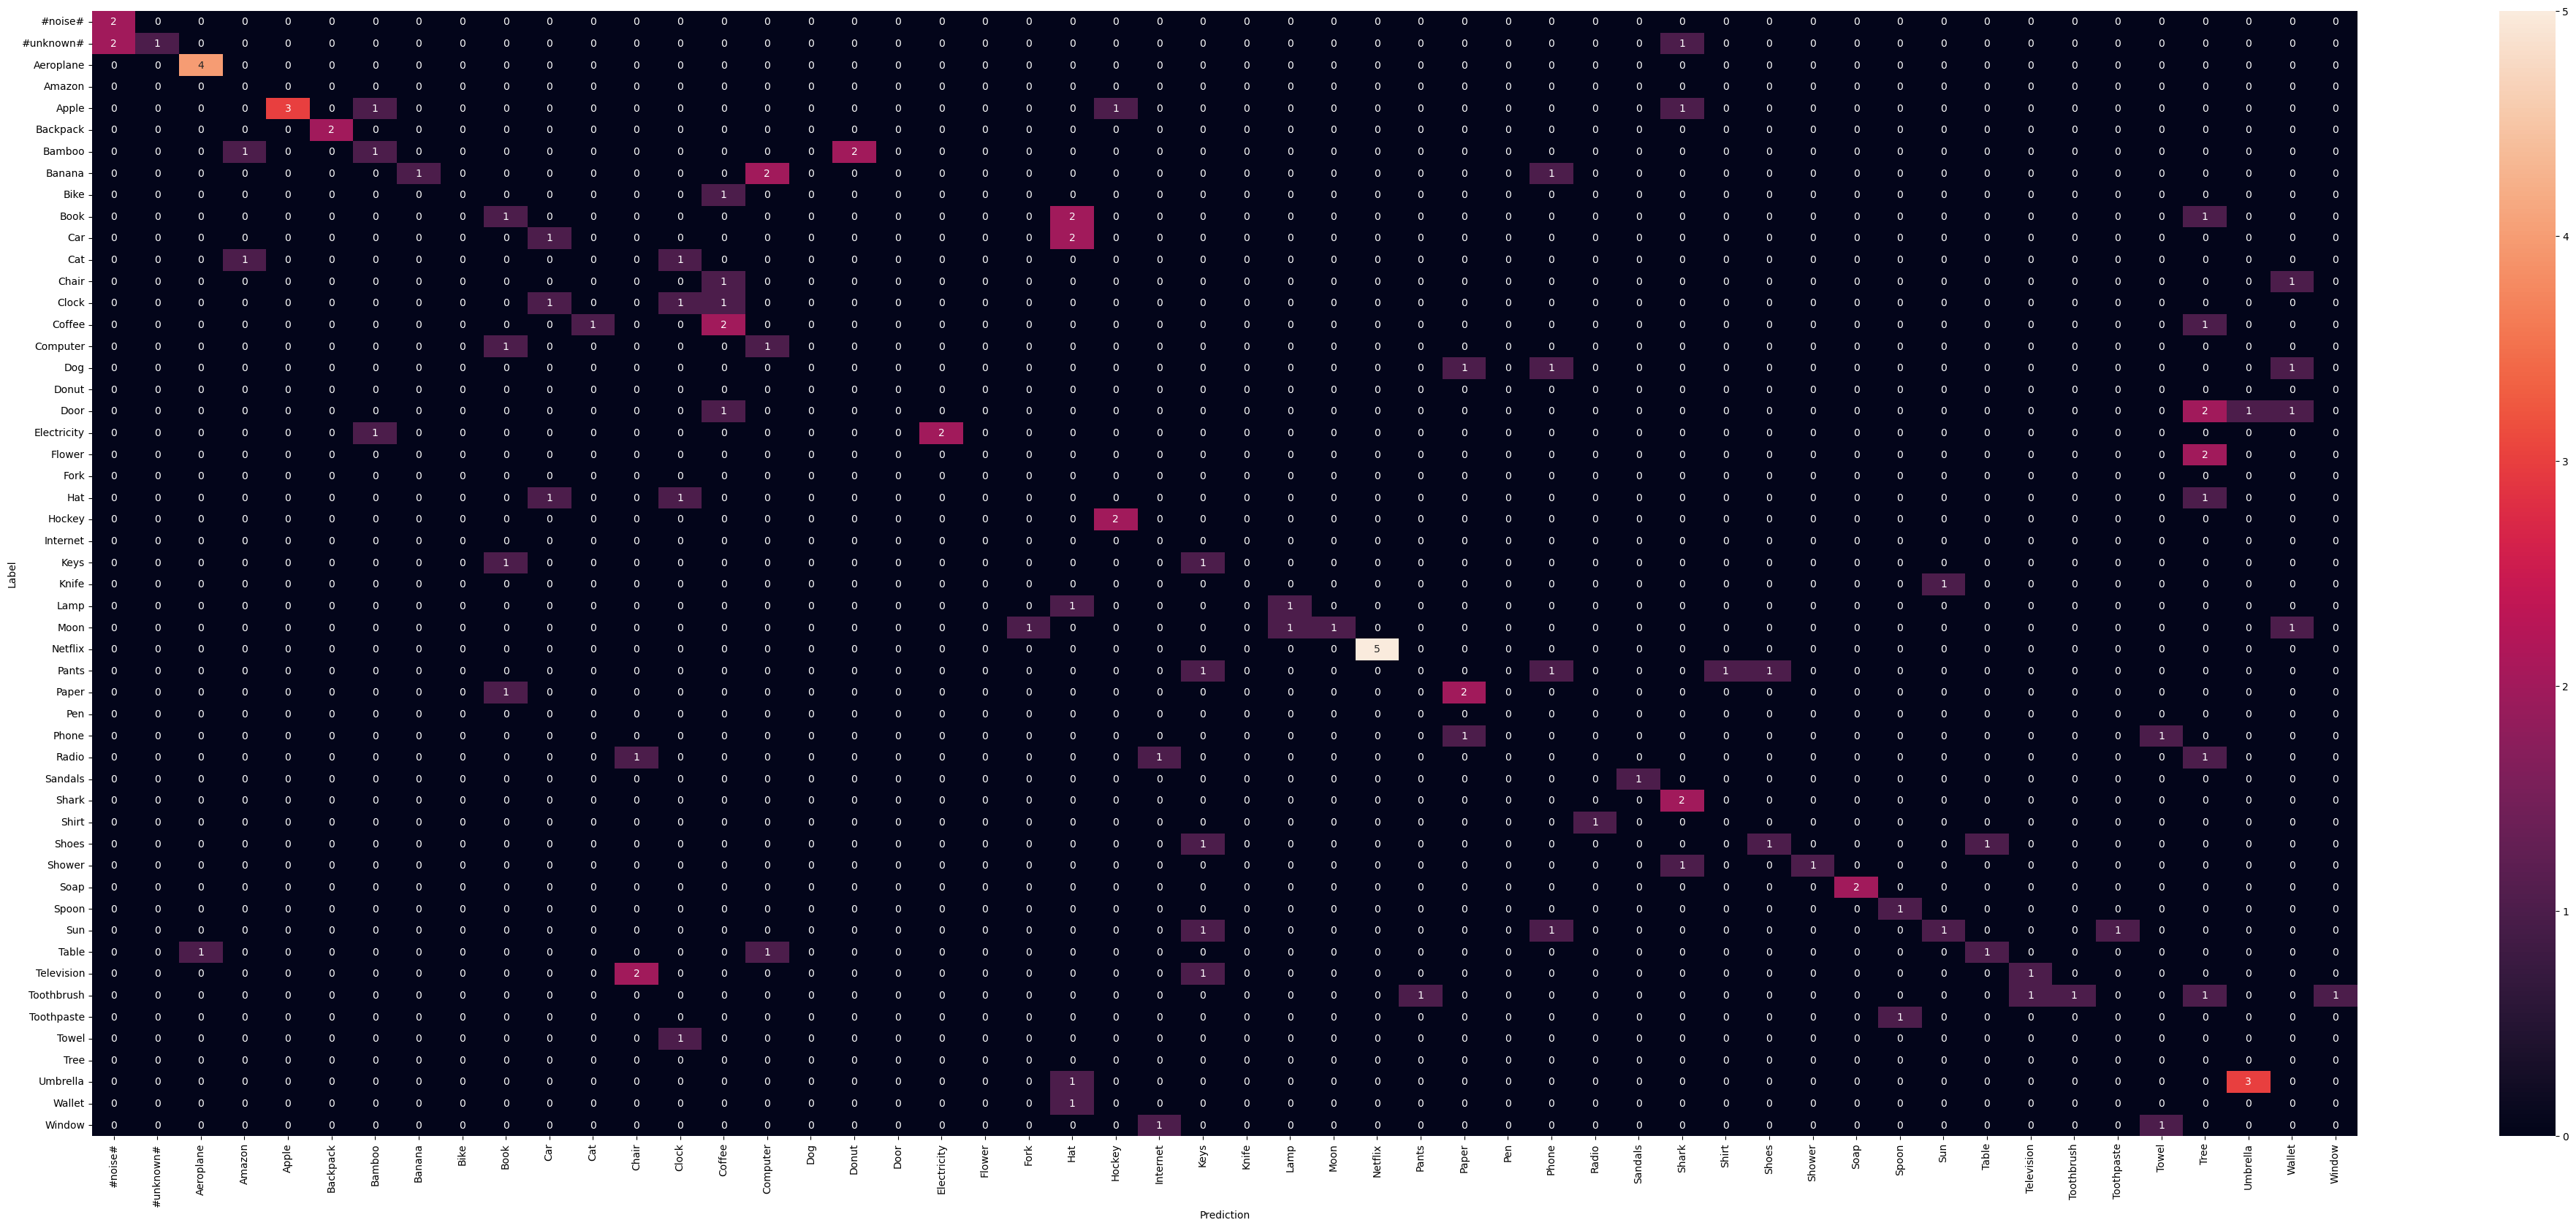

In [36]:
evaluate_model(model_birnn_1)

Test Accuracy and Loss Values : {'loss': 1.7833583354949951, 'accuracy': 0.5546875}
1/1 [==============================] - 0s 426ms/step


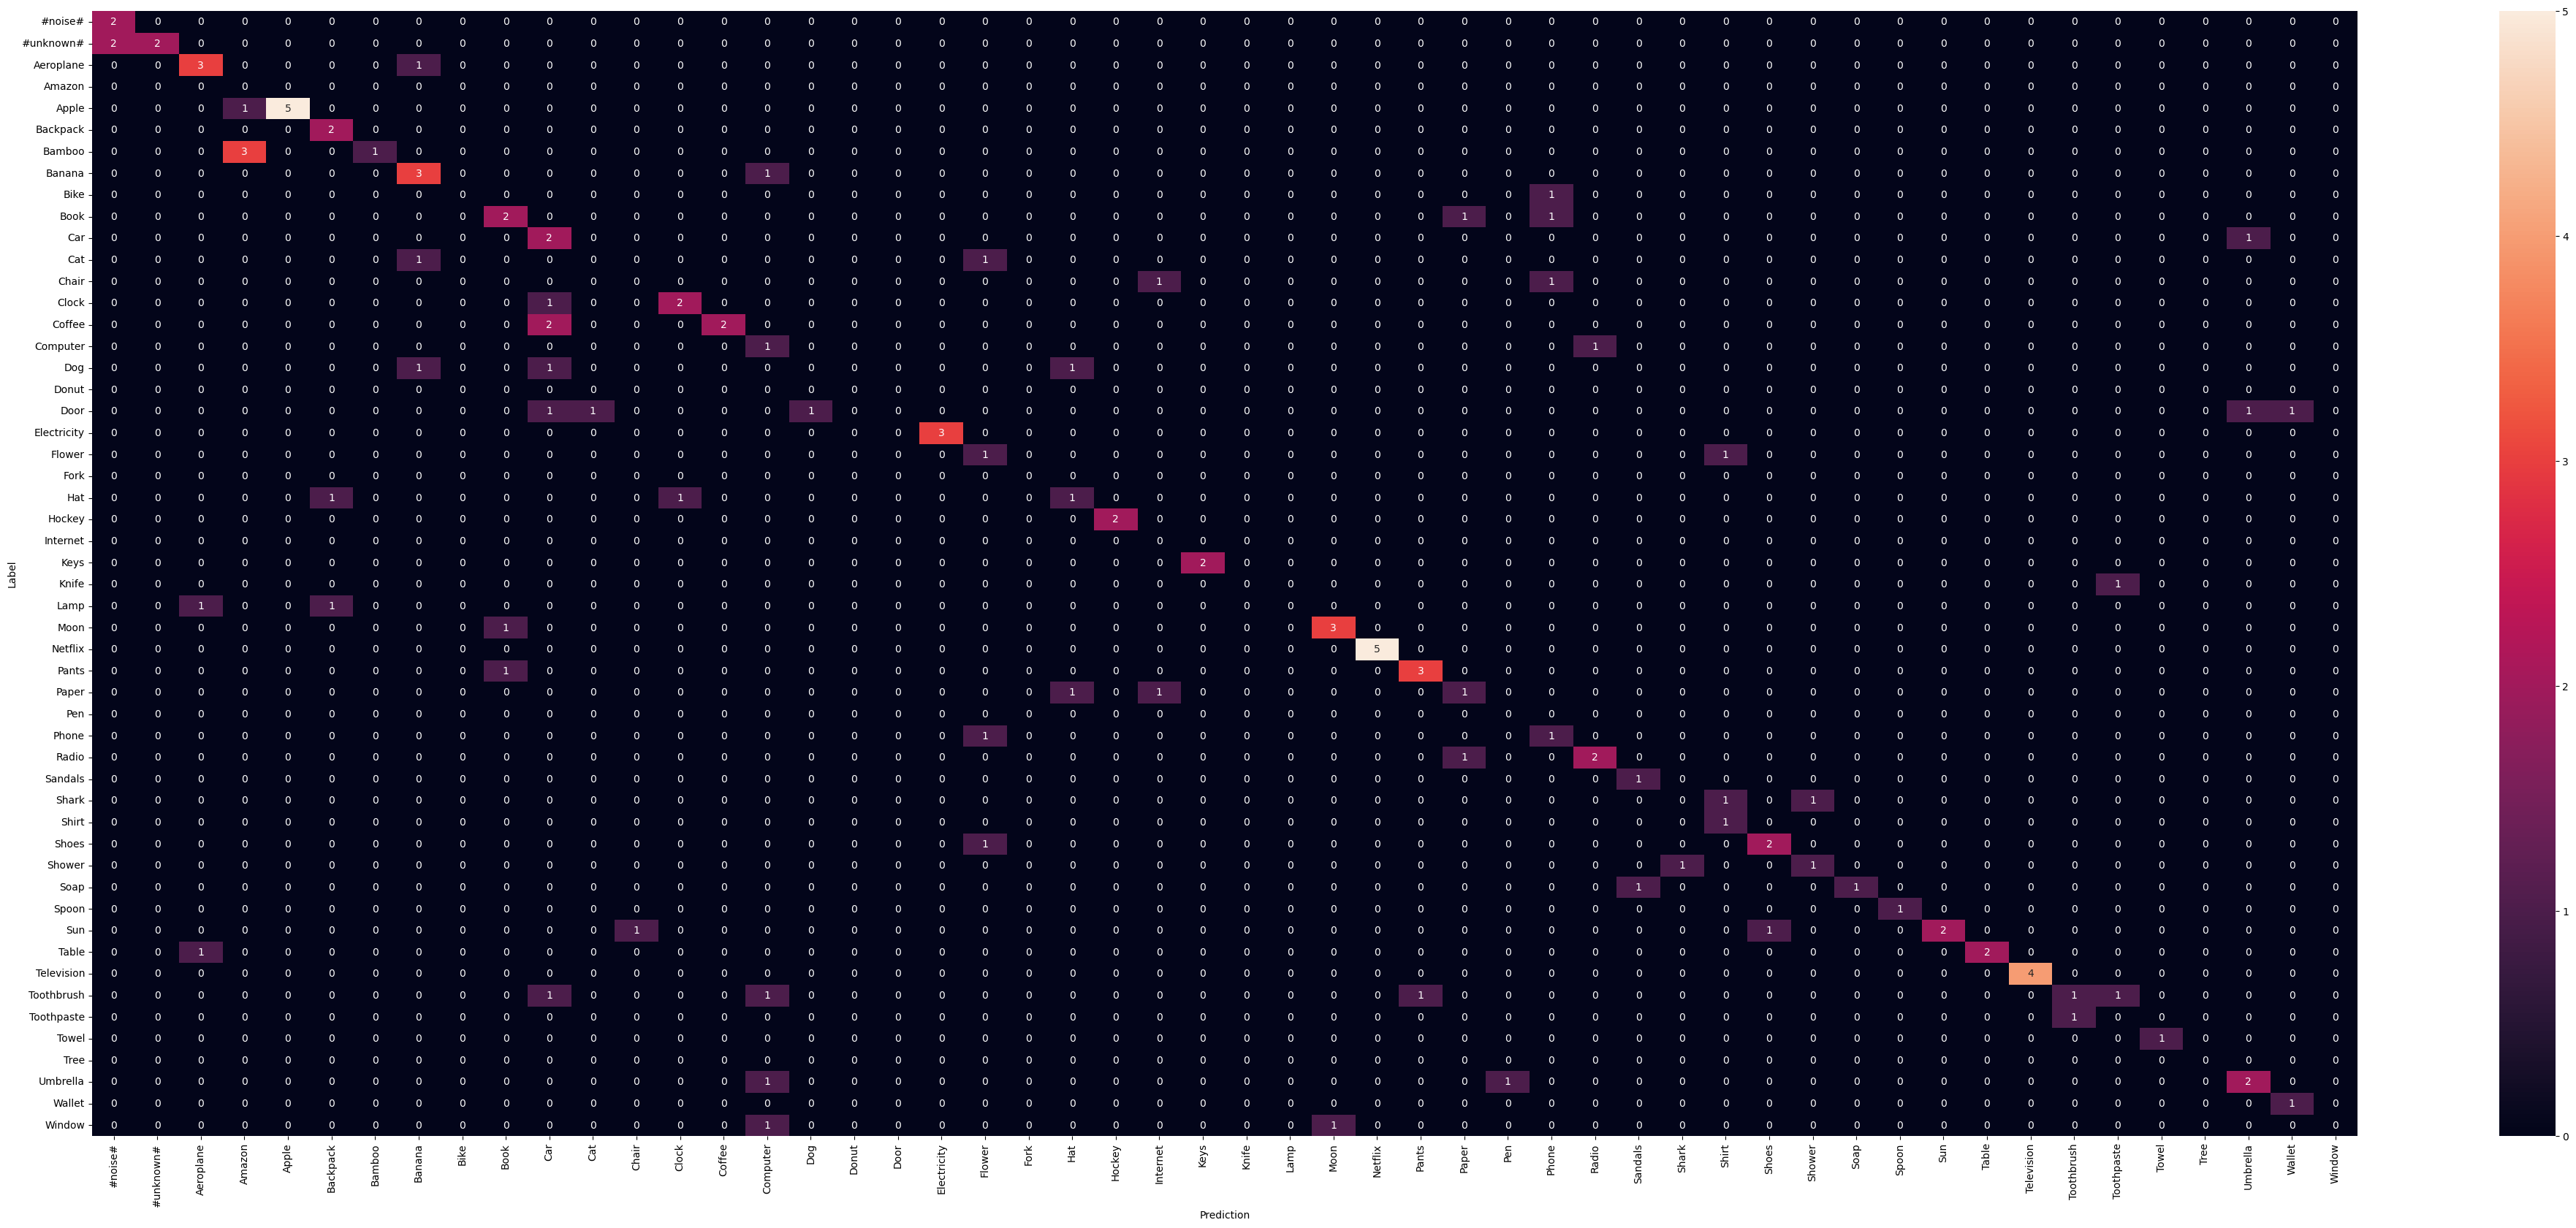

In [37]:
evaluate_model(model_crnn_1)

Test Accuracy and Loss Values : {'loss': 1.4571551084518433, 'accuracy': 0.671875}
1/1 [==============================] - 0s 467ms/step


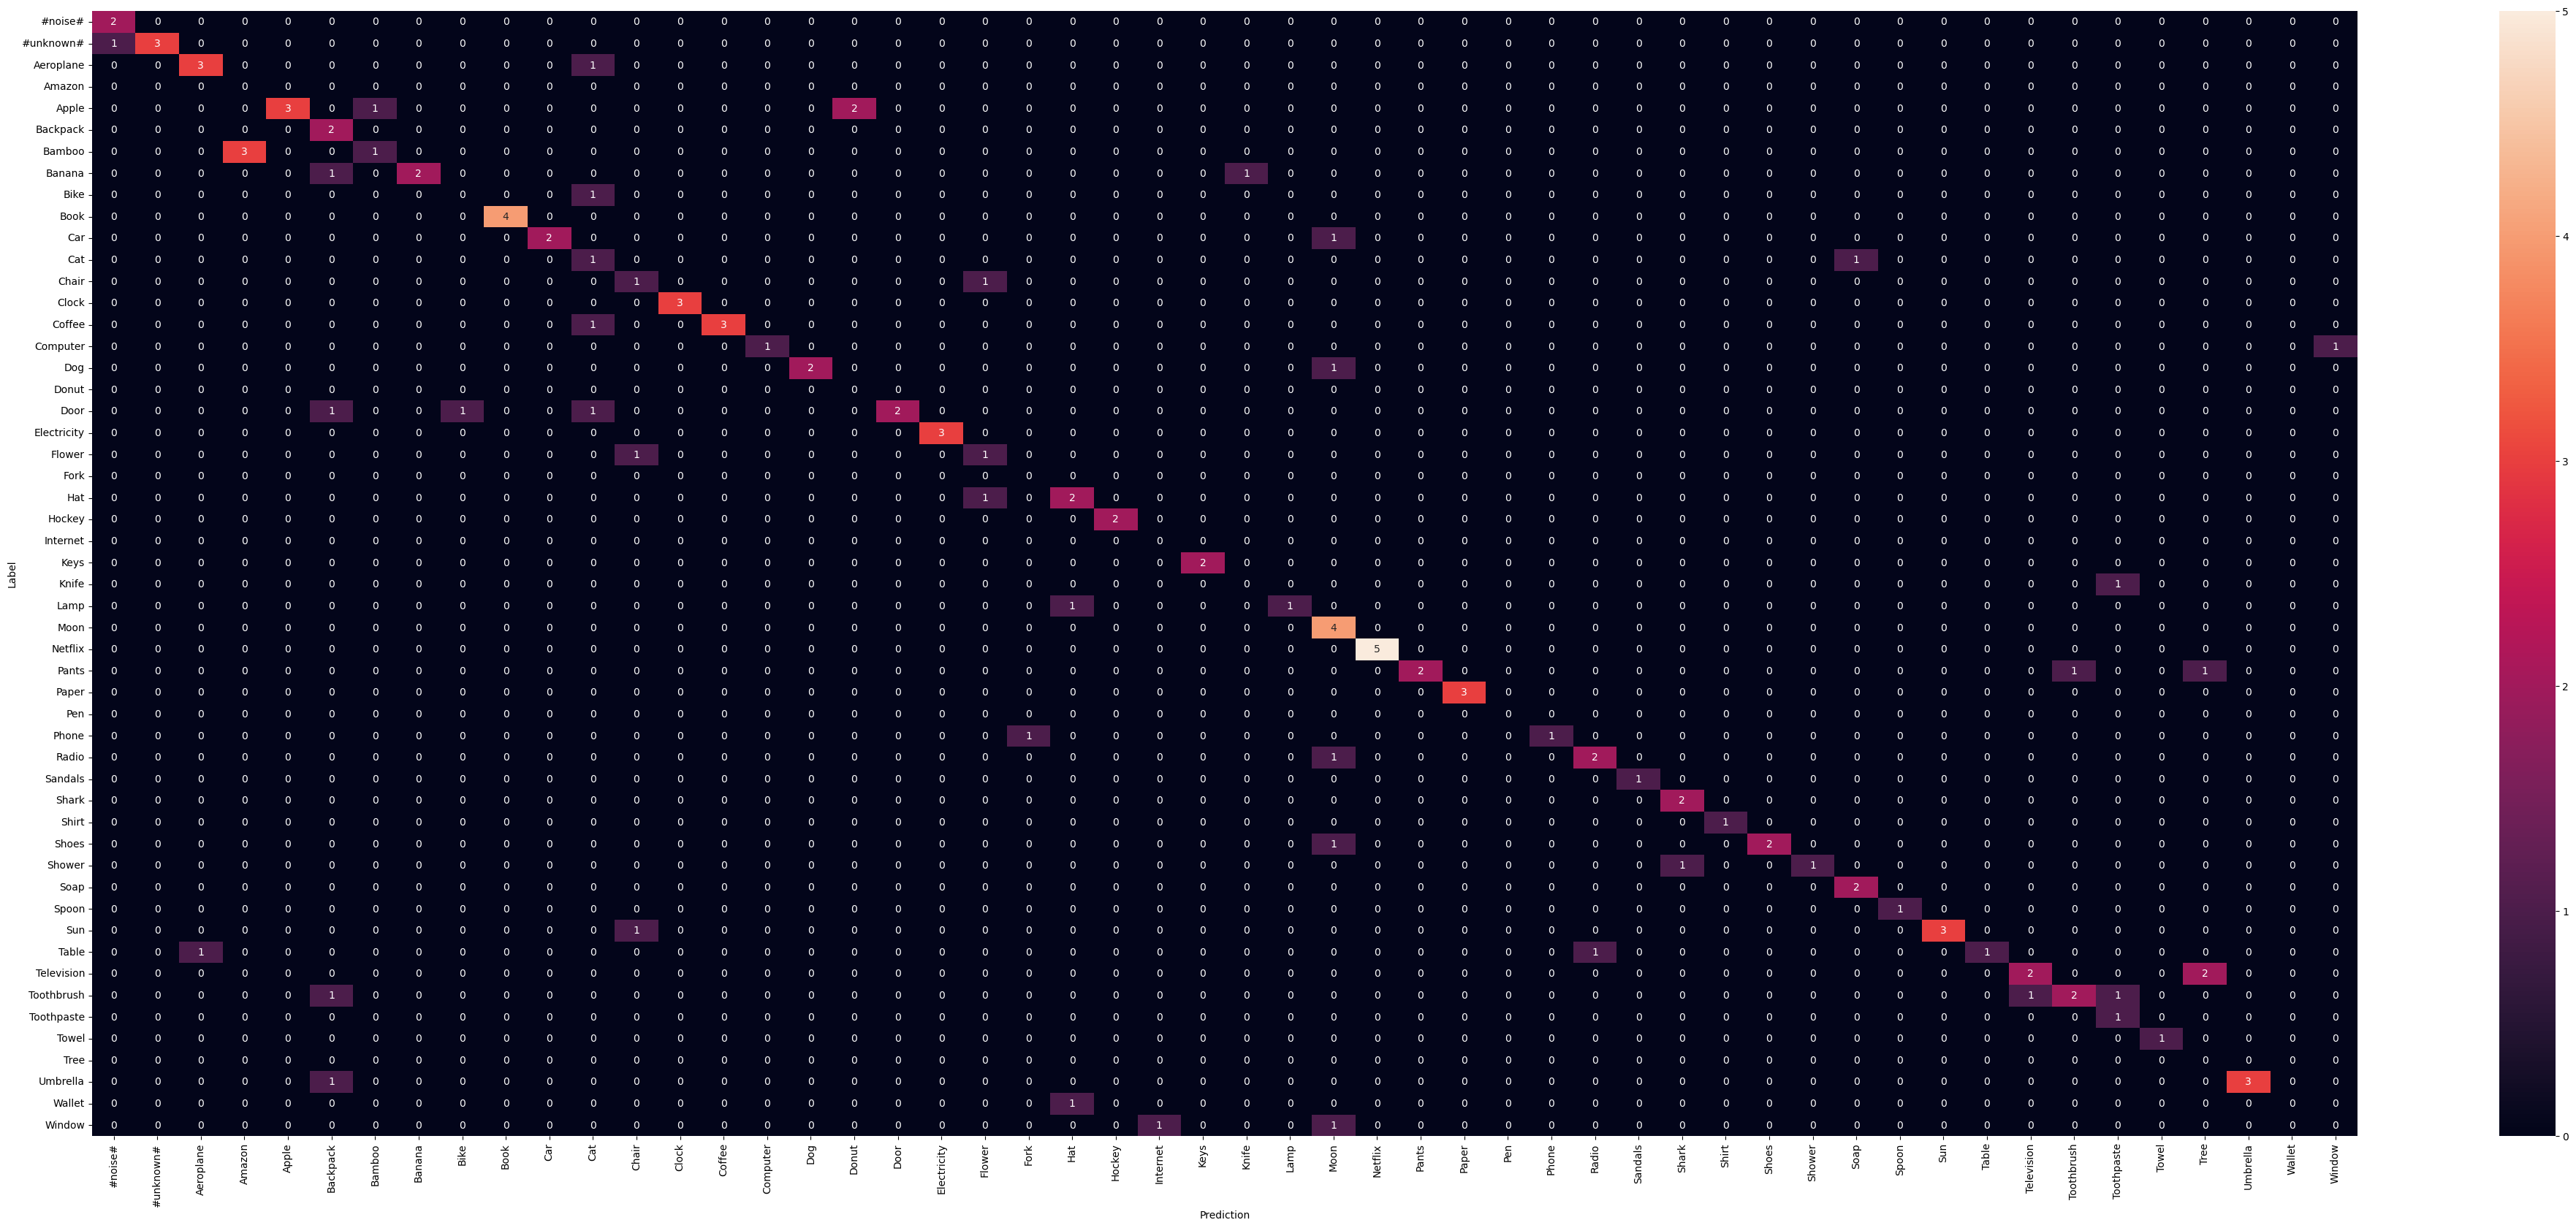

In [38]:
evaluate_model(model_crnn_2)

In [39]:
class ExportModel(tf.Module) :
  def __init__(self, model) :

    self.model = model
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string),
    )
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=[None, sampling_rate], dtype=tf.float32)
    )

  @tf.function
  def __call__(self, x) :
    if x.dtype == tf.string :
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=sampling_rate,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, ...]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(labels, class_ids)
    return {
        'predictions' : result,
        'class_ids' : class_ids,
        'class_names' : class_names
    }


#### Calculation of Prediction Latency for 100 random audio samples

In [41]:
import os
import random

def get_audio_files(path):
    audio_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".wav"):
                audio_files.append(os.path.join(root, file))
    return audio_files

def pick_random_files(files, num_files=100):
    return random.sample(files, min(num_files, len(files)))

# Example usage:
path_to_folder = "Audio_Dataset_9"
audio_files = get_audio_files(path_to_folder)
random_files = pick_random_files(audio_files)
print(len(random_files))


100


In [42]:
def get_class_names(random_files) :
    classes = []
    for file in random_files : 
        classes.append(file.split("/")[1])
    
    return classes

actual_classes = get_class_names(random_files)

In [43]:
def calculate_percentage_equal(array1, array2):
    if len(array1) != len(array2):
        raise ValueError("Arrays must be of the same length")
    
    equal_count = sum(1 for a, b in zip(array1, array2) if a == b)
    total_samples = len(array1)
    percentage_equal = (equal_count / total_samples) * 100
    print(f"Accuracy of Predictions : {percentage_equal}")
    return percentage_equal

In [44]:
def predictions(model_name, model) :

    predicted_classes = []
    start_time = time()
    for audio_file in random_files : 
        output_tensor = model(tf.constant(audio_file))["class_names"]
        output_string = output_tensor.numpy()[0].decode('utf-8')  
        predicted_classes.append(output_string)

    end_time = time()
    latency = end_time - start_time
    print(f"Prediction Latency of {model_name} for 100 audio samples is {latency}")
    prediction_latencies.append(latency)
    prediction_accuracy = calculate_percentage_equal(actual_classes, predicted_classes)
    prediction_accuracies.append(prediction_accuracy)


In [46]:
export = ExportModel(model_gru_2)
tf.saved_model.save(export, 'saved/models/model_gru_2')
reloaded_model = tf.saved_model.load("saved/models/model_gru_2")
predictions("GRU 2", reloaded_model)

INFO:tensorflow:Assets written to: saved/models/model_gru_2/assets


INFO:tensorflow:Assets written to: saved/models/model_gru_2/assets


Prediction Latency of GRU 2 for 100 audio samples is 0.9170050621032715
Accuracy of Predictions : 21.0


In [47]:
export = ExportModel(model_birnn_1)
tf.saved_model.save(export, 'saved/models/model_birnn_1')
reloaded_model = tf.saved_model.load("saved/models/model_birnn_1")
predictions("BiRNN 1", reloaded_model)

INFO:tensorflow:Assets written to: saved/models/model_birnn_1/assets


INFO:tensorflow:Assets written to: saved/models/model_birnn_1/assets


Prediction Latency of BiRNN 1 for 100 audio samples is 0.7723691463470459
Accuracy of Predictions : 31.0


In [48]:
export = ExportModel(model_crnn_1)
tf.saved_model.save(export, 'saved/models/model_crnn_1')
reloaded_model = tf.saved_model.load("saved/models/model_crnn_1")
predictions("CRNN 1", reloaded_model)

INFO:tensorflow:Assets written to: saved/models/model_crnn_1/assets


INFO:tensorflow:Assets written to: saved/models/model_crnn_1/assets


Prediction Latency of CRNN 1 for 100 audio samples is 0.54653000831604
Accuracy of Predictions : 34.0


In [49]:
export = ExportModel(model_crnn_2)
tf.saved_model.save(export, 'saved/models/model_crnn_2')
reloaded_model = tf.saved_model.load("saved/models/model_crnn_2")
predictions("CRNN 2", reloaded_model)

INFO:tensorflow:Assets written to: saved/models/model_crnn_2/assets


INFO:tensorflow:Assets written to: saved/models/model_crnn_2/assets


Prediction Latency of CRNN 2 for 100 audio samples is 0.7825179100036621
Accuracy of Predictions : 47.0


In [69]:
import pandas as pd
def create_tables() :
    latency_table = pd.DataFrame({
        "RNN Model" : model_names,
        "Hidden Units" : hidden_units,
        "Training Latency" : training_latencies,
        "Prediction Latency" : prediction_latencies
    })

    os.makedirs('Evaluation_Metrics',  exist_ok=True) 
    latency_table.to_csv('Evaluation_Metrics/Latency_table')

    metrics_table = pd.DataFrame({
        "RNN Model" : model_names,
        "Hidden Units" : hidden_units,
        "Training Accuracy" : training_accuracies,
        "Training Loss" : training_losses,
        "Validation Accuracy" : validation_accuracies,
        "Validation Loss" : validation_losses,
        "Testing Accuracy" : testing_accuracies,
        "Testing Loss" : testing_losses,
        "Prediction Accuracy" : prediction_accuracies
    })
    metrics_table.to_csv('Evaluation_Metrics/Metrics_Table')

create_tables()

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers

In [70]:
import pandas as pd

df1 = pd.read_csv('Evaluation_Metrics_0/Metrics_Table')
df2 = pd.read_csv('Evaluation_Metrics_1/Metrics_Table')
df3 = pd.read_csv('Evaluation_Metrics_2/Metrics_Table')

In [76]:
[df2['Training Accuracy'][3], df2['Training Accuracy'][4],df2['Training Accuracy'][6],df2['Training Accuracy'][7]]

[0.887499988079071, 0.9122596383094788, 0.9365384578704834, 0.9675480723381042]

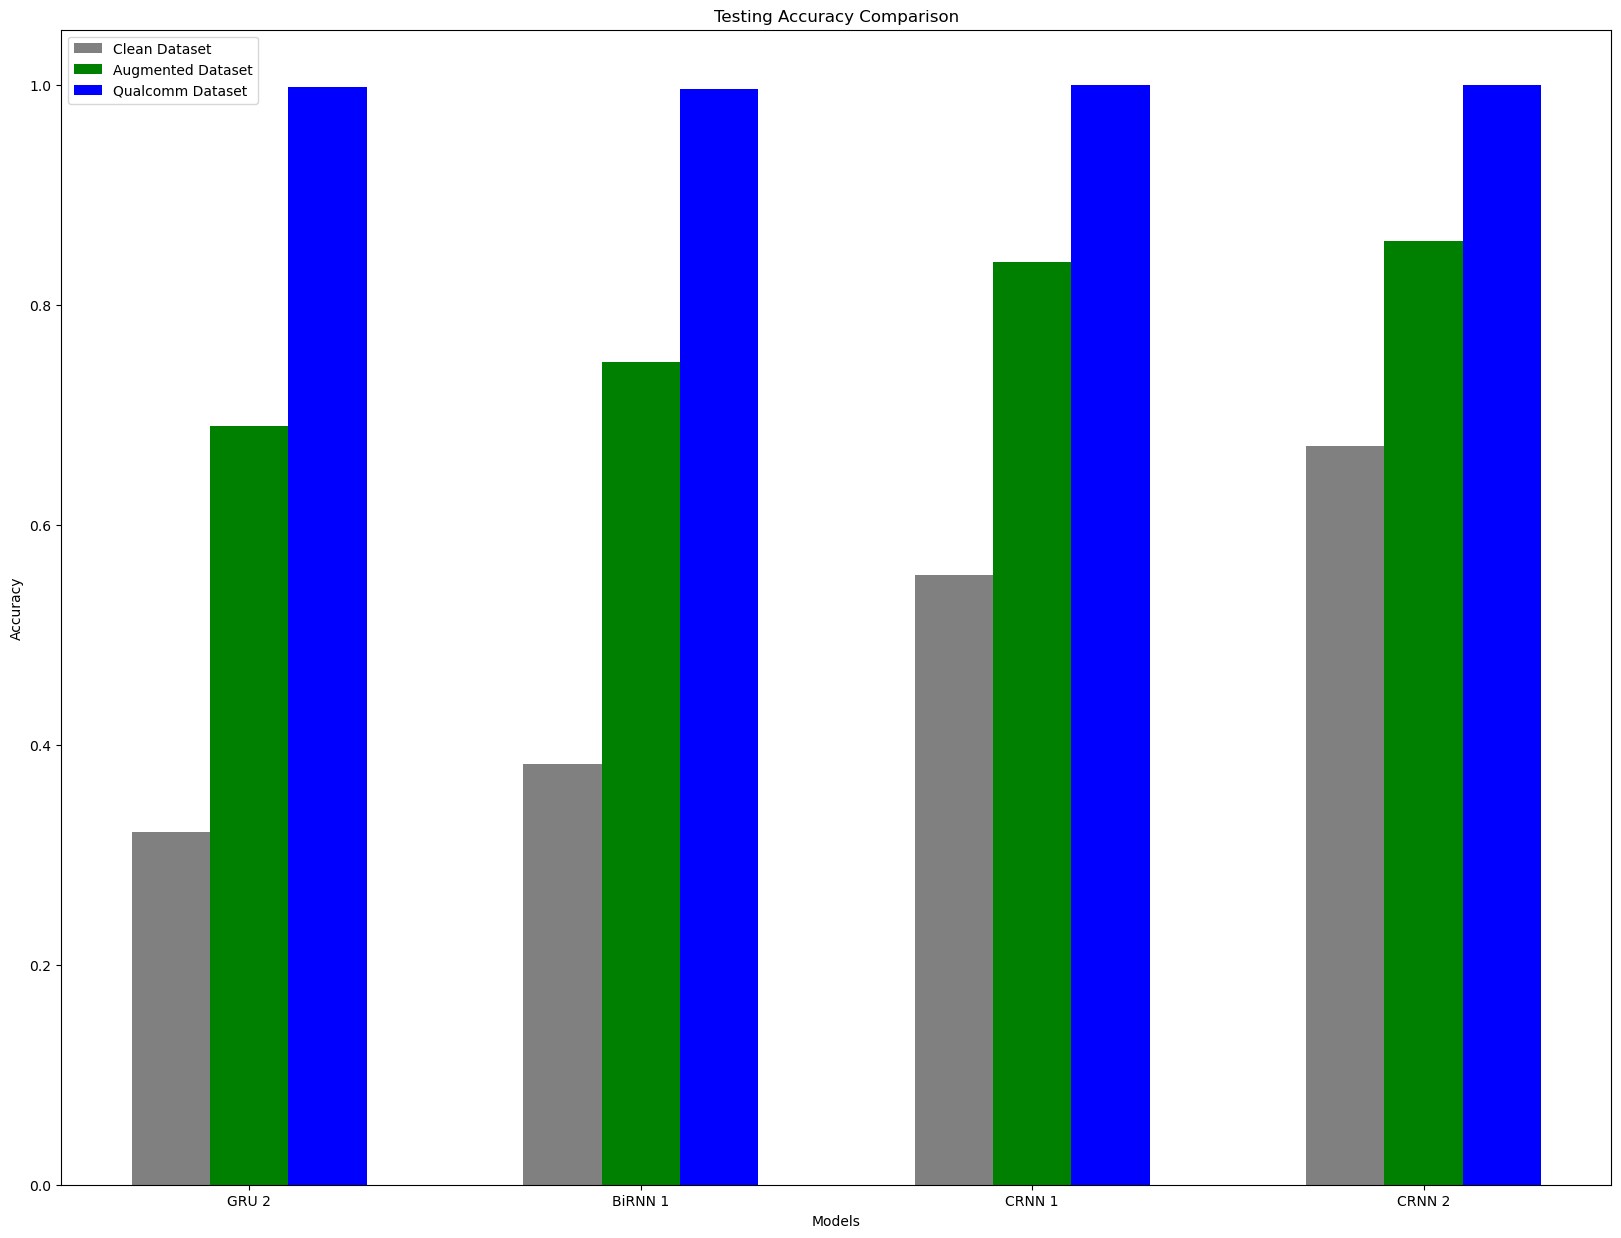

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
values1 = df1['Testing Accuracy']
values2 = [df2['Testing Accuracy'][3], df2['Testing Accuracy'][4],df2['Testing Accuracy'][6],df2['Testing Accuracy'][7]]
values3 = [df3['Testing Accuracy'][3], df3['Testing Accuracy'][4],df3['Testing Accuracy'][6],df3['Testing Accuracy'][7]]

# Width of each bar
bar_width = 0.2

# Index for each category
x = np.arange(len(model_names))

plt.figure(figsize=(20, 15))
# Plotting bars for each category
plt.bar(x - bar_width, values1, width=bar_width, color='gray', align='center', label='Clean Dataset')
plt.bar(x, values2, width=bar_width, color='g', align='center', label='Augmented Dataset')
plt.bar(x + bar_width, values3, width=bar_width, color='blue', align='center', label='Qualcomm Dataset')

# X-axis labels
plt.xticks(x, model_names)

# Labeling the bars
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy Comparison')
plt.legend(loc="upper left")

# Display the plot
plt.show()
